# Project Notebook 06: Enhanced RNN Classification


## **Objective:**
### Train an RNN (LSTM) to classify chess puzzles into "Easy", "Medium", or "Hard".




In [ ]:
# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score
# sklearn embedding for regression plot


# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configure plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Data Loading & Preprocessing

In [ ]:
# Load Data (50k sample for speed, a GPU can use more!)
try:
    df = pd.read_csv('puzzles.csv', nrows=50000)
except FileNotFoundError:
    raise FileNotFoundError("puzzles.csv not found.")

# Create Classification Target (Easy < Medium < Hard)
bins = [0, 1200, 1800, 3000]
labels = ['Easy', 'Medium', 'Hard']
df['difficulty_bin'] = pd.cut(df['Rating'], bins=bins, labels=labels, right=False)
df.dropna(subset=['difficulty_bin'], inplace=True)

# Features (X) and Target (y)
X_raw = df['FEN'].astype(str).values
y_raw = df['difficulty_bin'].values

# Encode Target Manually to ensure 0=Easy, 1=Medium, 2=Hard
label_map = {'Easy': 0, 'Medium': 1, 'Hard': 2}
y_encoded = np.array([label_map[label] for label in y_raw])
y_categorical = to_categorical(y_encoded, num_classes=3)

print(f"Data Loaded: {len(df)} samples")
print(f"Class Distribution:\n{df['difficulty_bin'].value_counts(normalize=True)}")

Data Loaded: 49986 samples
Class Distribution:
difficulty_bin
Easy      0.358280
Medium    0.352819
Hard      0.288901
Name: proportion, dtype: float64


## 3. Optimized Tokenization

In [5]:

# Limit vocab size to speed up training (most frequent chars only)
MAX_VOCAB = 50 
tokenizer = Tokenizer(char_level=True, lower=False, num_words=MAX_VOCAB)
tokenizer.fit_on_texts(X_raw)
X_seq = tokenizer.texts_to_sequences(X_raw)

# Pad sequences
MAX_LEN = 70
X_padded = pad_sequences(X_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Input Shape: {X_padded.shape}")

Input Shape: (49986, 70)


## 4. Enhanced RNN Model

In [6]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

# Build the RNN Model
model = Sequential([
    Embedding(input_dim=MAX_VOCAB + 1, output_dim=64),
    
    # Bidirectional LSTM with Dropout
    Bidirectional(LSTM(64, return_sequences=False, dropout=0.2)),
    
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    # Output Layer: 3 neurons (Easy/Med/Hard)
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


## 5. Train with Callbacks

In [ ]:
# Stop if not improving, and reduce learning rate if stuck
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15, # Allow more epochs with early stopping
    batch_size=128, # Larger batch size for speed
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.3762 - loss: 1.0890 - val_accuracy: 0.3827 - val_loss: 1.0854 - learning_rate: 0.0010
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.3975 - loss: 1.0809 - val_accuracy: 0.3906 - val_loss: 1.0800 - learning_rate: 0.0010
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.3974 - loss: 1.0780 - val_accuracy: 0.4044 - val_loss: 1.0754 - learning_rate: 0.0010
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.4022 - loss: 1.0754 - val_accuracy: 0.3938 - val_loss: 1.0760 - learning_rate: 0.0010
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.3988 - loss: 1.0743 - val_accuracy: 0.4026 - val_loss: 1.0735 - learning_rate: 0.0010
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.4089 - loss: 1.0727 - val_accuracy: 0.4061 - val_loss: 1.0737 - learning_rate: 0.0010
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.4078 - l


## 6. Itemized Performance Table (Accuracy per Class)



--- Model Performance by Category ---
          Total Puzzles  Correctly Identified % Correct (Accuracy)
Category                                                          
Easy               3588                  1737               48.41%
Medium             3471                  1727               49.76%
Hard               2939                   695               23.65%
TOTAL              9998                  4159               41.60%


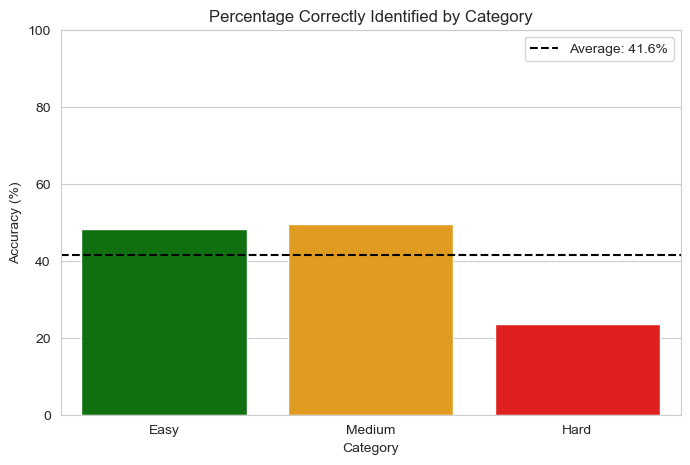

In [19]:

# Calculate Accuracy for each class separately
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Extract counts
correct_predictions = np.diag(cm)
total_per_class = np.sum(cm, axis=1)

# Calculate percentages
class_accuracy = correct_predictions / total_per_class * 100
total_accuracy = accuracy_score(y_true_classes, y_pred_classes) * 100

# Create a clean DataFrame for the report
performance_df = pd.DataFrame({
    'Category': class_names + ['TOTAL'],
    'Total Puzzles': np.append(total_per_class, np.sum(total_per_class)),
    'Correctly Identified': np.append(correct_predictions, np.sum(correct_predictions)),
    '% Correct (Accuracy)': np.append(class_accuracy, total_accuracy)
})

# Format for display
performance_df['% Correct (Accuracy)'] = performance_df['% Correct (Accuracy)'].map('{:.2f}%'.format)
performance_df.set_index('Category', inplace=True)

print("\n--- Model Performance by Category ---")
print(performance_df)

# Plot as a Bar Chart for visuals
plt.figure(figsize=(8, 5))
sns.barplot(x=performance_df.index[:-1], y=class_accuracy, hue=performance_df.index[:-1], palette=['green', 'orange', 'red'], legend=False)
plt.axhline(y=total_accuracy, color='black', linestyle='--', label=f'Average: {total_accuracy:.1f}%')
plt.title('Percentage Correctly Identified by Category')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.legend()
plt.show()

#### Not very accurate in the 'Hard' bin!

## 7. Zoned Regression Visualization: Predicted vs. Actual (With Categorical Regions)

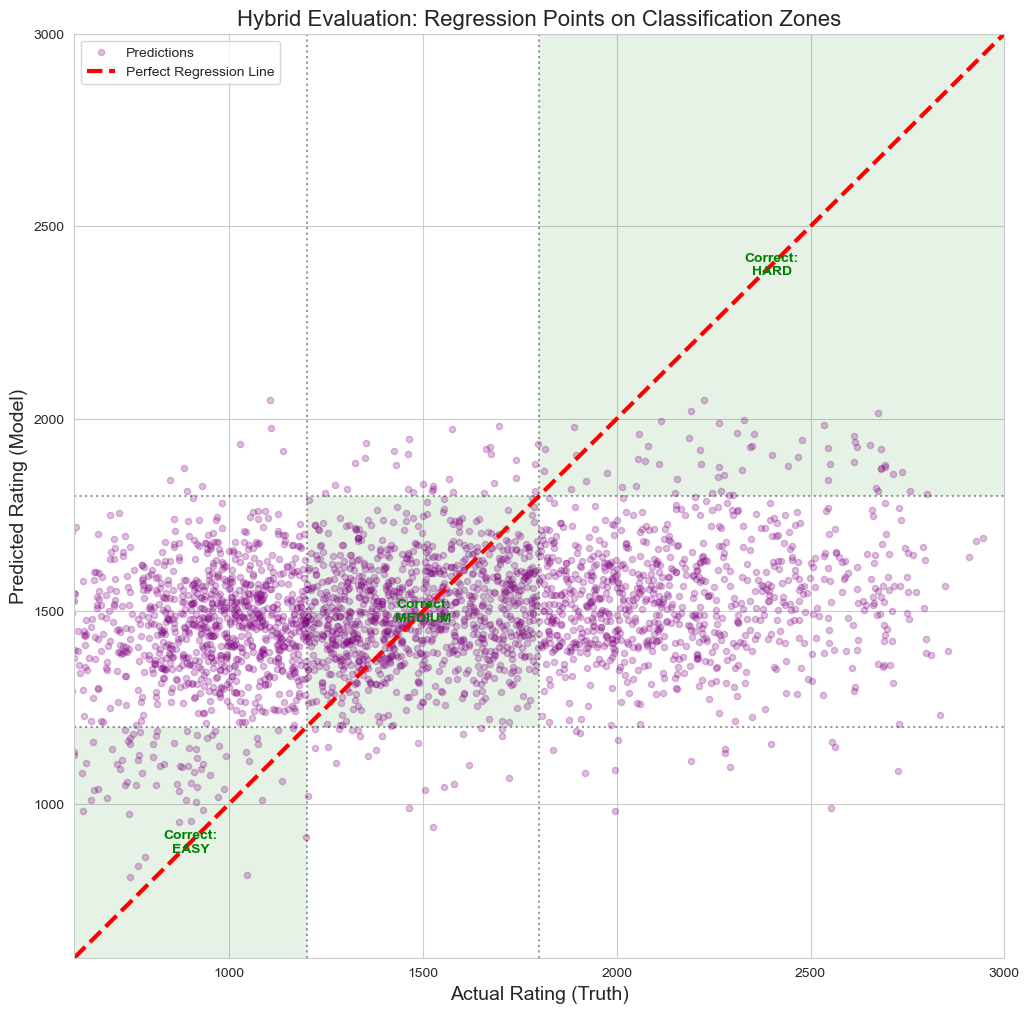

In [ ]:

#Zone
import matplotlib.patches as patches

plt.figure(figsize=(12, 12))

# 1. Define the Zones (Easy: 0-1200, Medium: 1200-1800, Hard: 1800-3000)
# Rectangles for the "Correct" classification boxes
zones = [
    (0, 1200, 0, 1200),       # Easy-Easy
    (1200, 1800, 1200, 1800), # Medium-Medium
    (1800, 3100, 1800, 3100)  # Hard-Hard
]

ax = plt.gca()
for (x1, x2, y1, y2) in zones:
    # Add a shaded box for correct classification regions
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=0, edgecolor='none', facecolor='green', alpha=0.1)
    ax.add_patch(rect)

# 2. Plot the Scatter Points (The Data)
# Plot a sample to prevent overcrowding
sample_indices = np.random.choice(len(y_test_real), 3000, replace=False)
plt.scatter(y_test_real[sample_indices], y_pred_real[sample_indices], 
            alpha=0.25, s=20, color='purple', label='Predictions')

# 3. Reference Lines
plt.plot([600, 3000], [600, 3000], 'r--', lw=3, label='Perfect Regression Line')

# Grid lines for the category boundaries
boundary_args = {'color': 'black', 'linestyle': ':', 'alpha': 0.4}
plt.axvline(1200, **boundary_args)
plt.axvline(1800, **boundary_args)
plt.axhline(1200, **boundary_args)
plt.axhline(1800, **boundary_args)

# 4. Labels
plt.xlabel("Actual Rating (Truth)", fontsize=14)
plt.ylabel("Predicted Rating (Model)", fontsize=14)
plt.title("Hybrid Evaluation: Regression Points on Classification Zones", fontsize=16)
plt.legend(loc='upper left')
plt.xlim(600, 3000)
plt.ylim(600, 3000)

# Add simple text labels for the diagonal boxes
plt.text(900, 900, "Correct:\nEASY", ha='center', va='center', color='green', fontweight='bold')
plt.text(1500, 1500, "Correct:\nMEDIUM", ha='center', va='center', color='green', fontweight='bold')
plt.text(2400, 2400, "Correct:\nHARD", ha='center', va='center', color='green', fontweight='bold')

plt.show()

#### Perhaps the model is finding the middle of the road to be safe?  It does appear biased.